In [138]:
import itertools as it
import warnings
from collections import deque
from typing import Callable, Dict, Tuple

import multiprocess as mp
import pandas as pd
import scipy.stats as stats
from tqdm.notebook import tqdm

from edgedroid.models import *

execution_time_models: Dict[str, Callable[[], ExecutionTimeModel]] = {
    "ED2 LN"                    : lambda: ExpKernelRollingTTFETModel(neuroticism=0.0),
    "ED2 HN"                    : lambda: ExpKernelRollingTTFETModel(neuroticism=1.0),
    "ED2 LN, ExG fit"           : lambda: DistExpKernelRollingTTFETModel(neuroticism=0.0, dist=stats.exponnorm),
    "ED2 HN, ExG fit"           : lambda: DistExpKernelRollingTTFETModel(neuroticism=1.0, dist=stats.exponnorm),
    "reference, gaussian fit"   : lambda: FittedNaiveExecutionTimeModel(dist=stats.norm)
}


def junjues_adaptive_sampling(
        repetition: int,
        # ground_truth: str,
        estimator: str,
        number_of_steps: int,
        processing_delay: float,
        # latency_bound: float = 3.2,
        max_delta_t: float,
        alpha: float = 3.0,
) -> pd.DataFrame:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gt_model = ExpKernelRollingTTFETModel(neuroticism=1.0)
        estimator_model = execution_time_models[estimator]()
    previous_ttf = processing_delay

    # max_ts = (latency_bound - processing_delay) / (5 - 1)

    min_sr = 1 / max_delta_t
    max_sr = 1 / processing_delay

    assert min_sr < max_sr

    rows = deque()
    total_duration = 0.0

    for step in range(number_of_steps):
        gt_model.advance(previous_ttf)
        estimator_model.advance(previous_ttf)

        instant = 0.0
        execution_time = gt_model.get_execution_time()
        samples = 0

        while instant <= execution_time:
            sr = min(min_sr + (alpha * (max_sr - min_sr) * estimator_model.get_cdf_at_instant(instant)), max_sr)
            instant = instant + (1 / sr)
            samples += 1

        duration = instant + processing_delay
        total_duration += duration
        ttf = duration - execution_time
        wait_time = ttf - processing_delay

        rows.append(
            {
                # "ground_truth"       : ground_truth,
                "sampling"           : f"Adaptive ({estimator})",
                "proc_delay"         : processing_delay,
                "repetition"         : repetition,
                "step"               : step + 1,
                "execution_time"     : execution_time,
                "step_duration"      : duration,
                "cumulative_duration": total_duration,
                "ttf"                : ttf,
                "wait_time"          : wait_time,
                "samples"            : samples,
            }
        )

    return pd.DataFrame(rows)

def greedy_sampling(
        repetition: int,
        # ground_truth: str,
        number_of_steps: int,
        processing_delay: float,
) -> pd.DataFrame:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gt_model = ExpKernelRollingTTFETModel(neuroticism=1.0)

    rows = deque()
    prev_ttf = processing_delay
    total_duration = 0.0

    for step in range(number_of_steps):
        samples = 1
        instant = 0.0
        exec_time = gt_model.advance(prev_ttf).get_execution_time()

        while instant <= exec_time:
            samples += 1
            instant += processing_delay

        duration = instant + processing_delay
        total_duration += duration

        duration = instant + processing_delay
        total_duration += duration
        ttf = duration - exec_time
        wait_time = ttf - processing_delay

        rows.append(
            {
                # "ground_truth"       : ground_truth,
                "sampling"           : "Greedy",
                "proc_delay"         : processing_delay,
                "repetition"         : repetition,
                "step"               : step + 1,
                "execution_time"     : exec_time,
                "step_duration"      : duration,
                "cumulative_duration": total_duration,
                "ttf"                : ttf,
                "wait_time"          : wait_time,
                "samples"            : samples,
            }
        )

    return pd.DataFrame(rows)


processing_delays = [0.15, 0.3, 0.6]
max_delta_t = 2
repetitions = 90
num_steps = 100

results = deque()

with tqdm(total=(len(execution_time_models) + 1) * repetitions * len(processing_delays)) as bar, mp.Pool() as pool:
    def _callback(df: pd.DataFrame):
        results.append(df)
        bar.update()


    def _errback(error):
        raise error

    for estimator, processing_delay, rep in it.product(execution_time_models.keys(), processing_delays, range(1, repetitions + 1)):
        pool.apply_async(
            junjues_adaptive_sampling,
            kwds=dict(
                repetition=rep,
                # ground_truth=ground_truth,
                estimator=estimator,
                number_of_steps=num_steps,
                processing_delay=processing_delay,
                max_delta_t=max_delta_t,
            ),
            callback=_callback,
            error_callback=_errback,
        )

    for rep, processing_delay in it.product(range(1, repetitions + 1), processing_delays):
        pool.apply_async(
            greedy_sampling,
            kwds=dict(
                repetition=rep,
                # ground_truth=ground_truth,
                # estimator=estimator,
                number_of_steps=num_steps,
                processing_delay=processing_delay,
                # max_delta_t=max_delta_t,
            ),
            callback=_callback,
            error_callback=_errback,
        )

    pool.close()
    pool.join()

results = pd.concat(results)
# model_cats = pd.CategoricalDtype(["Greedy"] + list(execution_time_models.keys()), ordered=False)
# results["ground_truth"] = results["ground_truth"].astype(model_cats)
# results["sampling"] = results["sampling"].astype(model_cats)
results

  0%|          | 0/1620 [00:00<?, ?it/s]

,sampling,proc_delay,repetition,step,execution_time,step_duration,cumulative_duration,ttf,wait_time,samples
0,Adaptive (ED2 LN),0.15,8,1,6.269583,6.499999,6.499999,0.230415,0.080415,20
1,Adaptive (ED2 LN),0.15,8,2,3.449044,3.776263,10.276261,0.327219,0.177219,2
2,Adaptive (ED2 LN),0.15,8,3,6.469533,6.649999,16.926260,0.180465,0.030465,21
3,Adaptive (ED2 LN),0.15,8,4,6.955459,7.249999,24.176259,0.294540,0.144540,25
4,Adaptive (ED2 LN),0.15,8,5,4.619542,4.849999,29.026258,0.230456,0.080456,9
...,...,...,...,...,...,...,...,...,...,...
95,Greedy,0.60,90,96,3.158377,4.200000,1129.200000,1.041623,0.441623,7
96,Greedy,0.60,90,97,5.548803,6.600000,1142.400000,1.051197,0.451197,11
97,Greedy,0.60,90,98,4.886714,6.000000,1154.400000,1.113286,0.513286,10
98,Greedy,0.60,90,99,5.554027,6.600000,1167.600000,1.045973,0.445973,11


In [139]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2.5)
sns.set_palette("Dark2")

In [140]:
# mean number of samples per rep
samples_per_rep = results.groupby(["sampling", "proc_delay", "repetition"])["samples"].mean().reset_index()
samples_per_rep["proc_delay"] = samples_per_rep["proc_delay"].apply(lambda e: f"{int(e * 1000):} ms").astype(str)
samples_per_rep

,sampling,proc_delay,repetition,samples
0,Adaptive (ED2 HN),150 ms,1,12.00
1,Adaptive (ED2 HN),150 ms,2,14.63
2,Adaptive (ED2 HN),150 ms,3,13.52
3,Adaptive (ED2 HN),150 ms,4,17.21
4,Adaptive (ED2 HN),150 ms,5,13.88
...,...,...,...,...
1615,Greedy,600 ms,86,10.48
1616,Greedy,600 ms,87,9.97
1617,Greedy,600 ms,88,10.45
1618,Greedy,600 ms,89,10.11


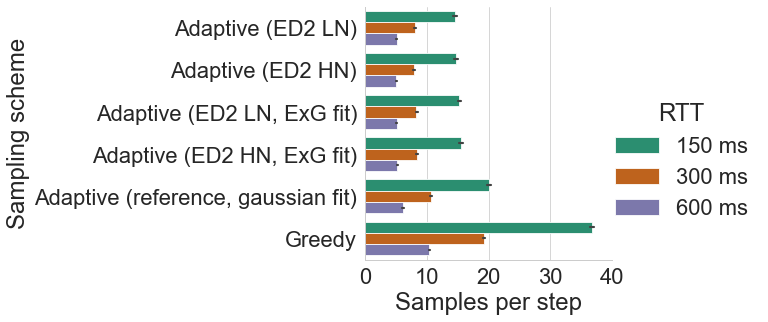

In [141]:
import numpy as np

fg = sns.catplot(
    kind="bar",
    # join=False,
    data=samples_per_rep,
    x="samples",
    hue="proc_delay",
    y="sampling",
    order=["Adaptive (ED2 LN)", "Adaptive (ED2 HN)", "Adaptive (ED2 LN, ExG fit)", "Adaptive (ED2 HN, ExG fit)", "Adaptive (reference, gaussian fit)", "Greedy"],
    aspect=2,
    height=5,
)
fg.set(xticks=np.linspace(0, 40, 5))
fg.legend.set_title("RTT")
fg.set_axis_labels("Samples per step", "Sampling scheme")
# for ax in fg.axes.flat:
#     for i in ax.containers:
#         ax.bar_label(i, padding=-50, fmt="%0.2f")
plt.show()

In [142]:
import pingouin as pg

ix = pd.IndexSlice

def diff_wrt_ref_rtt(df: pd.DataFrame) -> pd.DataFrame:
    ref_samples = df.loc[df["sampling"] == "Adaptive (reference, gaussian fit)", "samples"].to_numpy()
    ref_mean = ref_samples.mean()


    def diff_wrt_ref(samples: pd.Series) -> pd.Series:
        ttest = pg.ttest(samples.to_numpy(), ref_samples, alternative="two-sided")
        diff_raw = samples.mean() - ref_mean
        diff = diff_raw / ref_mean
        ci = ttest.at["T-test", "CI95%"]

        pval = ttest.at["T-test", "p-val"]
        sig_pval = pval < 0.05

        return pd.Series({
            "diff"     : diff,
            "diff_raw" : diff_raw,
            "p-val"    : pval,
            "p < 0.05" : sig_pval,
            "CI95_Low" : ci[0] / ref_mean,
            "CI95_High": ci[1] / ref_mean}, name="Result")

    return df.groupby("sampling")["samples"].apply(diff_wrt_ref)

samples_diff = samples_per_rep.groupby("proc_delay").apply(diff_wrt_ref_rtt).stack().stack().unstack(level=1).reset_index()
# samples_diff = samples_diff[samples_diff["sampling"] != "Adaptive (reference, gaussian fit)"]
# # samples_diff["sampling"] = samples_diff["sampling"].cat.remove_unused_categories()
samples_diff

,proc_delay,sampling,diff,diff_raw,p-val,p < 0.05,CI95_Low,CI95_High
0,150 ms,Adaptive (ED2 HN),-0.269671,-5.425667,0.0,True,-0.290762,-0.248514
1,150 ms,"Adaptive (ED2 HN, ExG fit)",-0.225905,-4.545111,0.0,True,-0.24752,-0.204279
2,150 ms,Adaptive (ED2 LN),-0.278137,-5.596,0.0,True,-0.300205,-0.25597
3,150 ms,"Adaptive (ED2 LN, ExG fit)",-0.242302,-4.875,0.0,True,-0.263425,-0.221178
4,150 ms,"Adaptive (reference, gaussian fit)",0.0,0.0,1.0,False,-0.022366,0.022366
5,150 ms,Greedy,0.829839,16.696,0.0,True,0.807175,0.852405
6,300 ms,Adaptive (ED2 HN),-0.256796,-2.739333,0.0,True,-0.276545,-0.237173
7,300 ms,"Adaptive (ED2 HN, ExG fit)",-0.219205,-2.338333,0.0,True,-0.239985,-0.1978
8,300 ms,Adaptive (ED2 LN),-0.240662,-2.567222,0.0,True,-0.262484,-0.219361
9,300 ms,"Adaptive (ED2 LN, ExG fit)",-0.222996,-2.378778,0.0,True,-0.244672,-0.20155


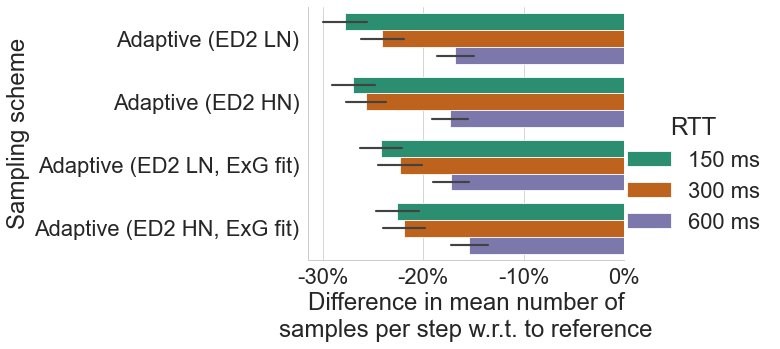

,sampling,proc_delay,level_2,values
2,Adaptive (ED2 HN),150 ms,diff,-0.269671
5,"Adaptive (ED2 HN, ExG fit)",150 ms,diff,-0.225905
8,Adaptive (ED2 LN),150 ms,diff,-0.278137
11,"Adaptive (ED2 LN, ExG fit)",150 ms,diff,-0.242302
14,"Adaptive (reference, gaussian fit)",150 ms,diff,0.0
17,Greedy,150 ms,diff,0.829839
20,Adaptive (ED2 HN),300 ms,diff,-0.256796
23,"Adaptive (ED2 HN, ExG fit)",300 ms,diff,-0.219205
26,Adaptive (ED2 LN),300 ms,diff,-0.240662
29,"Adaptive (ED2 LN, ExG fit)",300 ms,diff,-0.222996


In [143]:
import matplotlib.ticker as tkr

plot_data = samples_diff.set_index(["sampling", "proc_delay"])[["CI95_Low", "CI95_High", "diff"]].stack().reset_index().rename(columns={0: "values"})

fg = sns.catplot(
    kind="bar",
    data=plot_data,
    estimator=lambda e: sorted(e)[1],
    errorbar=lambda e: (min(e), max(e)),
    y="sampling",
    hue="proc_delay",
    x="values",
    order=["Adaptive (ED2 LN)", "Adaptive (ED2 HN)", "Adaptive (ED2 LN, ExG fit)", "Adaptive (ED2 HN, ExG fit)",],
    # hue="Configuration",
    aspect=2,
    height=5,
    # yerr=duration_diff["CI95%"].to_numpy(),
)
fg.legend.set_title("RTT")
fg.set_axis_labels("Difference in mean number of\nsamples per step w.r.t. to reference", "Sampling scheme")
# fg.set(xticks=np.linspace(-0.25, 0, 6))
for ax in fg.axes.flat:
    # ax.yaxis.set_major_locator(tkr.MaxNLocator(integer=True))
    # ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f"{y:0.0f}s"))
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f"{x:+0.0%}" if x != 0.0 else "0%"))
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=35, ha="right", rotation_mode="anchor")
plt.show()

plot_data[plot_data["level_2"] == "diff"]